In [1]:
# https://web.stanford.edu/class/cs294a/sparseAutoencoder.pdf
import numpy as np
import tqdm

In [2]:
def fetch(url):
    import requests, gzip, os, numpy, hashlib
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            data = f.read()
    else:
        with open(fp, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    return numpy.frombuffer(gzip.decompress(data), dtype=numpy.uint8).copy()

#https://pytorch.org/vision/main/_modules/torchvision/datasets/mnist.html#MNIST
mirror = 'https://ossci-datasets.s3.amazonaws.com/mnist/'
Xtr = fetch(f"{mirror}train-images-idx3-ubyte.gz")[0x10:].reshape(-1,28,28)
Xval= fetch(f"{mirror}t10k-images-idx3-ubyte.gz")[0x10:].reshape(-1,28,28)

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class SparseAutoEncoder(nn.Module):
    def __init__(self, inp_sz, n_hid):
        super(SparseAutoEncoder, self).__init__()
        self.encoder = nn.Linear(inp_sz, n_hid)
        self.decoder = nn.Linear(n_hid, inp_sz)
    
    def forward(self, x):
        h = self.encoder(x)
        x = self.decoder(torch.tanh(h))
        return x, h

In [129]:
input_sz = 784
hidden_sz = 1200 # contrain "feature compression" on the model
lr = 3e-4
wd = 0.01 #weight decay
beta = 3 #weight of sparsity penalty
rho = 0.05 # sparsity activation hyperparameter
epsilon = 0.1e-4 # to prevent log(0)

# dataset
X = torch.tensor(Xtr.reshape(len(Xtr), -1)).float()
BS = 32

device = torch.device('cuda')
model = SparseAutoEncoder(input_sz, hidden_sz).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lossi, sparsi = [], [] 

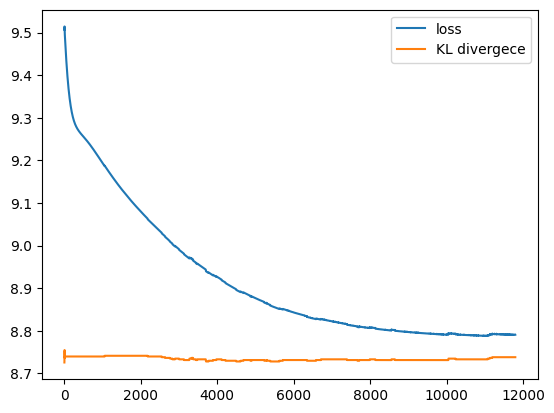

11632/100000, loss: 6571.6567, penalty: 6236.6348:  12%|█▏        | 11633/100000 [17:19<2:11:32, 11.20it/s]


KeyboardInterrupt: 

In [132]:
epoch = 100000 #ops 1 extra zero

for i in (t := tqdm.trange(epoch)):
    model.train()
    model.zero_grad()
    X = X.to(device)
    _x,z = model(X) # no batch?
    avg_z = torch.mean(z, 0)
    avg_z = torch.clamp(avg_z, min=epsilon, max=1-epsilon)
    # 1. sparsity penalty (KL divergence)
    rho_t = torch.full_like(avg_z, rho) #rho_tensor
    kl_divergence = rho_t * torch.log(rho_t/avg_z) + (1 - rho_t) * torch.log((1-rho_t) / (1-avg_z))
    sparsity_penalty = beta + torch.sum(kl_divergence)
    # 2. reconstruction loss
    r_loss = criterion(_x, X)
    # loss = 1 + 2
    loss = r_loss + sparsity_penalty
    lossi.append(loss.item())
    sparsi.append(sparsity_penalty.item())
    if i % 100 == 0:
        from IPython.display import clear_output
        plt.plot(np.log(np.array(lossi)), label='loss')
        plt.plot(np.log(np.array(sparsi)), label='KL divergece')
        plt.legend()
        clear_output(wait=True)
        plt.show()
    loss.backward()
    optimizer.step()
    t.set_description(f"{i}/{epoch}, loss: {loss.item():.4f}, penalty: {sparsity_penalty.item():.4f}")

In [133]:
model.eval()
img = torch.tensor(Xval).view(len(Xval), -1).float().to(device)
preds = model(img)[0]
(preds - img).abs().mean().item()

12.224664688110352

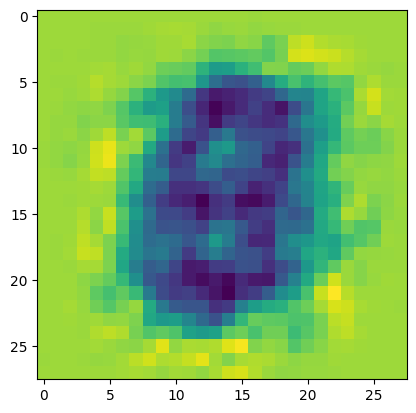

In [141]:
# it creates random noise to somewhat number looking lol
img = torch.randn(1,784).float().to(device)
preds = model(img)[0]
plt.imshow(preds.view(-1, 28).cpu().detach().numpy())

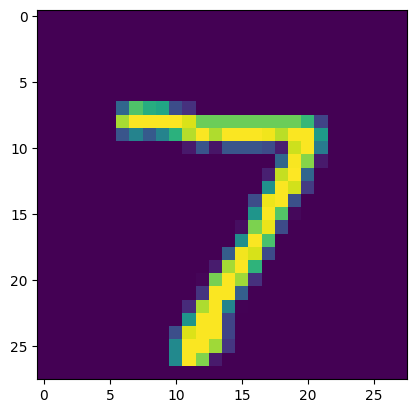

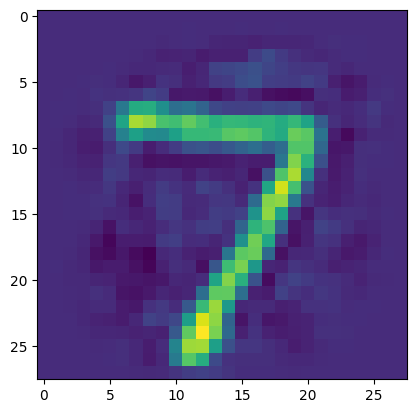

In [146]:
# image to image reconstruction
img = Xval[0]
plt.imshow(img)
plt.show()
img = torch.tensor(img).view(-1).float().to(device)
plt.imshow(model(img)[0].view(28,-1).cpu().detach().numpy())

In [147]:
torch.save(model.state_dict(), 'sparse_autoencoder.pth')